In [12]:
import os
import pickle
import pandas as pd
import numpy as np
import dask.dataframe as dd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, plot_confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, SGDClassifier
import catboost as cb

import matplotlib.pyplot as plt

In [2]:
PATH_TRAIN = 'data_train.csv'
PATH_TEST = 'data_test.csv'
PATH_FEATURES = 'features/features.csv'

In [3]:
%%time

df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)
df_features = dd.read_csv(PATH_FEATURES, sep='\t')

CPU times: total: 1.02 s
Wall time: 1.1 s


In [4]:
df_features.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float64(253), int64(3)

##### Отфильтруем датафрейм с признаками по пользователям

In [5]:
%%time

common_users = pd.concat([df_train, df_test]).id.unique()
df_features = df_features[df_features.id.isin(common_users)].compute()
del common_users

df_features.drop('Unnamed: 0', axis=1, inplace=True)
df_features.head(5)

CPU times: total: 12min 41s
Wall time: 2min 42s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
13,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
16,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
19,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
20,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
22,2075318,1533502800,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


In [6]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902389 entries, 13 to 12421
Columns: 255 entries, id to 252
dtypes: float64(253), int64(2)
memory usage: 1.7 GB


##### Соединим датафрейм признаков с train/test выборкой

In [7]:
def transform(df: pd.DataFrame, df_features: pd.DataFrame, isTrain: bool) -> pd.DataFrame:
    print(f"До соединения: {df.shape}")
    
    df = pd.merge(df, df_features, how='left', on='id')
    
    # Отбросим строки, в которых событие из `df_features` происходит на 2 дня позже или раньше, чем в `df`
    if isTrain:
        df = df[abs(df.buy_time_x - df.buy_time_y) > 172800]
    
    df.drop(['Unnamed: 0', 'buy_time_y'], axis=1, inplace=True)
    df.rename(columns={"buy_time_x": "buy_time"}, inplace=True)
    
    print(f"После соединения: {df.shape}")
    return df

In [8]:
%%time

df_features_groupby = df_features.groupby('id').first()

CPU times: total: 9.02 s
Wall time: 9.39 s


In [9]:
%%time

df_train = transform(df_train, df_features_groupby, True)
df_train.head(5)

Shape before transform: (831653, 5)
Shape after transform: (793804, 257)
CPU times: total: 4.45 s
Wall time: 4.47 s


,id,vas_id,buy_time,target,0,1,2,3,4,5,...,243,244,245,246,247,248,249,250,251,252
0,540968,8.0,1537131600,0.0,-31.559971,327.360888,-45.500786,274.753202,-50.918246,253.64821,...,-845.373846,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0
1,1454121,4.0,1531688400,0.0,547.270029,238.430888,533.329214,274.803202,527.911754,253.69821,...,-972.373846,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0
2,2458816,1.0,1534107600,0.0,-92.139971,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,...,-977.373846,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,3535012,5.0,1535922000,0.0,54.880029,12.970888,54.079214,-9.116798,48.661754,-30.22179,...,-977.373846,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0
4,1693214,1.0,1535922000,0.0,45.160029,295.240888,64.679214,344.283202,59.261754,323.17821,...,-965.373846,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0


In [10]:
# %%time

df_test = transform(df_test, df_features_groupby, False)
df_test.to_csv('data_test_new.csv')
df_test.head(5)

Shape before transform: (71231, 4)
Shape after transform: (71231, 256)


,id,vas_id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
0,3130519,2.0,1548018000,-62.899971,-374.279112,-72.600786,-418.406798,-78.018246,-439.51179,17.81382,...,-970.373846,-613.770792,-25.996269,-37.630448,-258.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2000860,4.0,1548018000,-96.799971,100.290888,-110.740786,140.903202,-116.158246,119.79821,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-254.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,1099444,2.0,1546808400,-81.969971,-390.729112,-95.910786,-443.336798,-101.328246,-464.44179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
3,1343255,5.0,1547413200,259.130029,-52.249112,245.189214,-104.856798,239.771754,-125.96179,-16.08618,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
4,1277040,2.0,1546808400,331.170029,590.890888,317.229214,538.283202,311.811754,522.25821,-16.08618,...,-651.373846,-612.770792,1.003731,-36.630448,38.252276,-12.832889,-0.694428,-12.175933,12.54386,0.0


### Подготовим выборки и протестируем разные модели

In [13]:
RANDOM_STATE = 100

In [14]:
def get_features(X: pd.DataFrame):
    assert isinstance(X, pd.DataFrame)
    
    X_nunique = X.apply(lambda x: x.nunique(dropna=False))

    f_init = set(X_nunique.index.tolist())
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_numeric = (X.fillna(0).astype(int).sum() - X.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    f_other = f_init - (f_numeric | f_const)
    f_binary = set(X.loc[:, f_other].columns[(
        (X.loc[:, f_other].max() == 1) & \
        (X.loc[:, f_other].min() == 0) & \
        (X.loc[:, f_other].isnull().sum() == 0)
    )])
    f_other = f_other - f_binary
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
    f_other = f_other - f_categorical
    f_numeric = f_numeric | f_other
    f_all = f_binary | f_categorical | f_numeric

    print('f_init:', len(f_init))
    print('f_const:', len(f_const))
    print('f_binary:', len(f_binary))
    print('f_categorical:', len(f_categorical))
    print('f_numeric:', len(f_numeric))
    
    assert(len(f_init) == len(f_const) + len(f_binary) + len(f_numeric) + len(f_categorical))

    return list(f_binary), list(f_categorical), list(f_numeric), list(f_all)

In [15]:
%%time

X = df_train.drop(['id', 'target'], axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=100,
    shuffle=True,
    stratify=y,
)

f_binary, f_categorical, f_numeric, f_all = get_features(X_train)
del df_train, X, y

f_init: 255
f_const: 5
f_binary: 0
f_categorical: 1
f_numeric: 249
CPU times: total: 8.8 s
Wall time: 8.99 s


In [16]:
def evaluate_model(model, X_test, y_test):
    y_test_pred = model.predict_proba(X_test)[:,1]
    print(f'{classification_report(y_test, y_test_pred > 0.5)}\n\n')

In [17]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("Датафрейм не содержит следующие колонки: %s" % cols_error)

In [ ]:
%%time

train_pipeline = make_pipeline(
    FeatureSelector(columns=f_all),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            FeatureSelector(columns=f_numeric),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            FeatureSelector(columns=f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ]),
    SelectFromModel(LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')),
)

models = {
    0: {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
        ),
    },
    1: {
        'name': 'SGDClassifier',
        'estimator': SGDClassifier(
            random_state=RANDOM_STATE,
            loss='log',
        ),
    },
    2: {
        'name': 'GradientBoostingClassifier',
        'estimator': GradientBoostingClassifier(
            random_state=RANDOM_STATE,
        )
    },
    3: {
        'name': 'CatBoostClassifier',
        'estimator': cb.CatBoostClassifier(
            random_state=RANDOM_STATE,
        )
    },
}

for key,value in models.items():
    
    print(f'{models[key]["name"]}')
    model = make_pipeline(
        train_pipeline,
        models[key]["estimator"],
    )
    model.fit(X_train, y_train)
    
    evaluate_model(model, X_test, y_test)

Результат работы моделей:

LogisticRegression
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    184026
         1.0       0.29      0.00      0.00     14425

    accuracy                           0.93    198451
   macro avg       0.61      0.50      0.48    198451
weighted avg       0.88      0.93      0.89    198451

SGDClassifier
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96    184026
         1.0       0.38      0.01      0.02     14425

    accuracy                           0.93    198451
   macro avg       0.65      0.51      0.49    198451
weighted avg       0.89      0.93      0.89    198451

GradientBoostingClassifier
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    184026
         1.0       0.67      0.27      0.39     14425

    accuracy                           0.94    198451
   macro avg       0.81      0.63      0.68    198451
weighted avg       0.93      0.94      0.92    198451

CatBoost

            precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    184026
         1.0       0.63      0.31      0.41     14425

    accuracy                           0.94    198451
   macro avg       0.79      0.65      0.69    198451
weighted avg       0.92      0.94      0.93    198451

##### GBM и Catboost показали примерно одинаковые результаты. Формируем финальную модель.

In [19]:
%%time

final_model = make_pipeline(
    train_pipeline,
    GradientBoostingClassifier(
        random_state=RANDOM_STATE,
        learning_rate=0.3,
        n_estimators=300,
        min_samples_split=2,
        max_depth=8,
    )
)

final_model.fit(X_train, y_train)

CPU times: total: 1h 14min 46s
Wall time: 1h 16min 16s


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('featureselector',
                                  FeatureSelector(columns=['111', '166', '247',
                                                           '127', '35', '186',
                                                           '135', '49', '61',
                                                           '171', '177', '11',
                                                           '79', '16', '240',
                                                           '250', '168', '165',
                                                           '183', '18', '115',
                                                           '181', '72', '232',
                                                           '100', '187', '12',
                                                           '157', '223', '130', ...])),
                                 ('featureunion',
                                  FeatureUnion(transformer_list=[('nu

In [20]:
evaluate_model(final_model, X_test, y_test)

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96    184026
         1.0       0.52      0.34      0.41     14425

    accuracy                           0.93    198451
   macro avg       0.73      0.66      0.69    198451
weighted avg       0.92      0.93      0.92    198451





deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


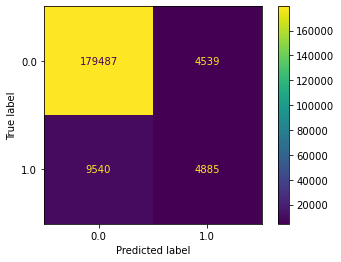

In [22]:
plot_confusion_matrix(final_model, X_test, y_test)
plt.show()

AUC_PR = 0.444
AUC_ROC = 0.916


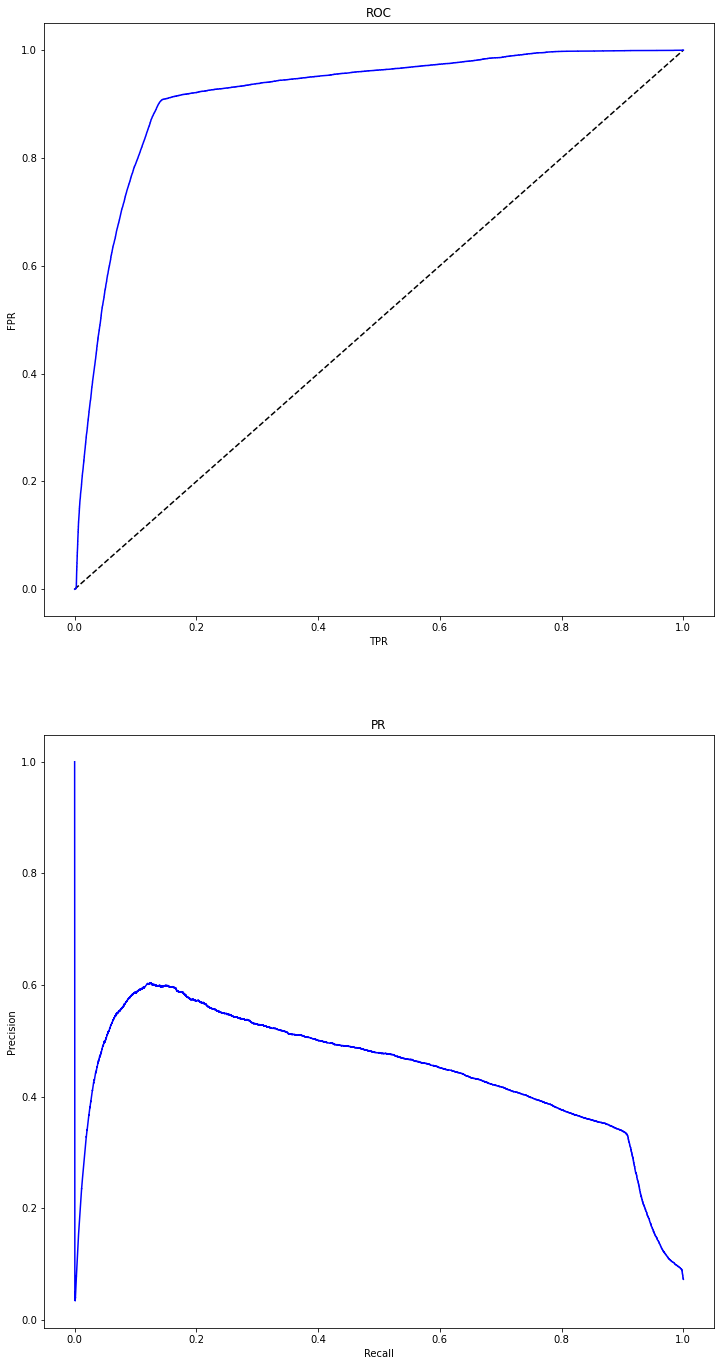

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')

ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

y_test_pred = final_model.predict_proba(X_test)[:,1]

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred)
ax1.plot(fpr, tpr, label='Baseline', color='b')
ax2.plot(recall, precision, label='Baseline', color='b')
print("AUC_PR = %.3f" % auc(recall, precision))
print("AUC_ROC = %.3f" % auc(fpr, tpr))

#### Сохраним модель

In [ ]:
with open('final_model.pkl', 'wb') as file:
        pickle.dump(final_model, file)